In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

In [49]:
################################################## HELPER FUNCTIONS #################################################################################### 
def z_scoring(x): 
    return (x - x.mean()) / x.std()

def range_normalization(x):
    return (x - x.mean()) / (x.max() - x.min())

def center_(x, cluster):
    return [np.mean(x[cluster, j]) for j in range(x.shape[1])]

# Used to group dataPoints in clusters
def distNorm(x ,remains, ranges, p):
    z = x[remains, :]
    az = np.tile(p, (len(remains), 1))
    rz = np.tile(ranges, (len(remains), 1))
    dz = (z - az) / rz
    return np.sum(dz * dz, axis=1)

# To See if it belongs to Cluster X?
def separCluster(x, remains, ranges, a, b):
    dista = distNorm(x, remains, ranges, a)
    distb = distNorm(x, remains, ranges, b)
    return [remains[i] for i in np.where(dista < distb)[0]]

def anomalousPattern(x, remains, ranges, centroid, me):
    while True:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if not cluster:
            break
        newcenter = center_(x, cluster)
        if np.allclose(centroid, newcenter):
            break
        centroid = newcenter
    return cluster, centroid

def dist(x, remains, ranges, p):
    return np.sum(((x[remains] - p) / ranges) ** 2, axis=1)

# Optimized Vectorized implementation
# Validation / Criterion
def xie_beni_index(U, centers, X):
    um = U ** 2
    dist_sq = np.sum((X[np.newaxis, :, :] - centers[:, np.newaxis, :]) ** 2, axis=2)
    compactness = np.sum(um * dist_sq)

    center_dist_sq = np.sum((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2, axis=2)
    np.fill_diagonal(center_dist_sq, np.inf)
    min_center_dist_sq = np.min(center_dist_sq)

    if min_center_dist_sq == 0:
        return np.inf
    return compactness / (X.shape[0] * min_center_dist_sq)


def pca_application(x_norm, y_values, init_centroids):
    # Covariance matrix of the normalized dataset
    covmatrix = np.cov(x_norm.T)

    # Eigenvalues and eigenvectors of the covariance matrix
    e, v = np.linalg.eig(covmatrix)

    # Order eigenvalues and eigenvectors in descending order
    order = np.argsort(e)[::-1]  # Sort eigenvalues in descending order
    e = e[order]
    v = v[:, order]

    # Print eigenvectors and eigenvalues
    #print("Eigenvectors:\n", v)
    print("\nEigenvalues:\n", e)

    # Generate PCA component space (PCA scores)
    pc = np.dot(x_norm, v)

    # Set data to a Pandas DataFrame for easier plotting
    names = ["PC_" + str(x + 1) for x in range(pc.shape[1])]
    names.append('target')
    data_pca = pd.DataFrame(data=np.c_[pc, y_values], columns=names)
    data_pca['target'] = data_pca['target'].astype(int)
    init_centroids_pca = np.dot(init_centroids, v)

    return data_pca, init_centroids_pca

def plot_2d_3d_pca(data_pca, fuzzy_membership, c, initial_centroids=None):
    # 2D PCA Visualization for fuzzy partitions
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC_1', y='PC_2', data=data_pca, hue=fuzzy_membership, palette='Set1', 
                    style=fuzzy_membership, markers='o', s=70, alpha=0.6)
    
    if initial_centroids is not None:
        plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], c='black', s=200, marker='X', label='Initial Centers')

    plt.title(f'PCA Projection of Data with {c} Clusters (Fuzzy C-Means - AP-FCM)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 0.5))
    plt.show()

    # 3D PCA Visualization for fuzzy partitions
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_pca['PC_1'], data_pca['PC_2'], data_pca['PC_3'], c=fuzzy_membership, cmap='Set1')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'3D PCA Projection of Data with {c} Clusters (Fuzzy C-Means - AP-FCM)')
    plt.show()

def plot_svd_projection(x_norm, x_values, y_values, fuzzy_membership):
    # Perform SVD on the normalized data
    u, s, vh = np.linalg.svd(x_norm, full_matrices=True)

    # Projected coordinates of the data points (first two principal components in SVD space)
    u1 = u[:, 0] * s[0]
    u2 = u[:, 1] * s[1]

    # Set data to a Pandas DataFrame for easier plotting
    names_svd = ["U_" + str(x + 1) for x in range(2)]
    names_svd.append('target')
    ds_us = pd.DataFrame(data=np.c_[u1, u2, y_values], columns=names_svd)
    ds_us['target'] = ds_us['target'].astype(int)

    # SVD Projection: Plotting 2D (first two projections)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='U_1', y='U_2', data=ds_us, hue=fuzzy_membership, palette='viridis', 
                    s=70, alpha=0.6, marker='o')  # Use only filled markers ('o')
    plt.title('SVD Projecting Wine Data with Quality Labels')
    plt.xlabel('Projection 1 (SVD)')
    plt.ylabel('Projection 2 (SVD)')
    plt.legend(title='Quality')
    plt.show()

    # Cumulative variance explained by the components
    var_explained = np.cumsum(s**2) / np.sum(s**2) * 100

    # Approximation for different numbers of components
    approx = []
    for n in range(1, x_values.shape[1] + 1):
        approximation = np.dot((u[:, :n] * s[:n]), vh[:n, :])
        approx.append(approximation)

        fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(16, 4))

        sns.regplot(x=approximation[:, 0], y=approximation[:, 2], fit_reg=False, scatter_kws={'alpha': 0.3}, ax=ax1)
        ax1.set(xlabel='Feature 1', ylabel='Feature 3', title=f'{n} component(s) retained, {var_explained[n - 1]:.2f}% variance')

        sns.regplot(x=x_norm[:, 0], y=x_norm[:, 2], fit_reg=False, scatter_kws={'alpha': 0.3}, ax=ax2)
        ax2.set(xlabel='Feature 1', ylabel='Feature 3', title='Original Dataset')

    plt.show()

In [50]:
################################################## DATA PREPARATION #################################################################################### 
# MERGED dataSet
df_r = pd.read_csv("./data/winequality-red.csv", sep=';')
df_w = pd.read_csv("./data/winequality-white.csv", sep=';')
data = pd.concat([df_r, df_w], ignore_index=True)

# Extract features and target
x_values = data.drop(columns=['quality']).values  # features (excluding 'quality')
y_values = data['quality'].values  # target (quality)

x = x_values.astype(np.float32)

# 0 (Default) - Range // 1 - z-score
normalization = 0
threshold = 25

#number of data points
nn = x.shape[0]
#number of features
mm = x.shape[1]
# grand means
me = []
# std
std = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# "anomalous cluster" ancl is the data structure to keep everything together
ancl = []
for j in range(mm): # for each feature
    z = x[:, j]     # data column vector j-th feature
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    std.append(np.std(z))

    if normalization:
        ranges.append(std[j])
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1
    
x_norm = np.divide((x - me), ranges)
sY = np.array(x_norm)
d = np.sum(sY * sY)   # total data scatter of normalized data

# x, me range, d
remains = list(range(nn))  # current index set of residual data after some anomalous clusters are extracted
numberC = 0; # counter of anomalous clusters 
while(len(remains) != 0):
    distance = dist(x, remains, ranges, me) # finding normalised distance vector from remains data points to reference 'me'
    ind = np.argmax(distance)
    index = remains[ind]
    centroid = x[index, :]   # initial anomalous center reference point: the one with higher distance
    numberC = numberC + 1
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me) # finding AP cluster
    
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges)) # standardised centroid with parameters of the data   
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d)) # cluster contribution (per cent) - (lecture on K-means and iK-means)

    remains = np.setdiff1d(remains, cluster) 
    # update the data structure that keeps everything together
    ancl.append((cluster, censtand, dD))

ancl = np.array(ancl, dtype=object)

##aK = numberC
b = 3
ll = [] # list of clusters

for ik in range(numberC):
    ll.append(len(ancl[ik, 0]))
    
rl = [i for i in ll if i >= threshold] # list of clusters with at least threshold elements
cent = []
if(len(rl) == 0):
    print('Too great a threhsold!!!')
else:
    num_cents = 0
    for ik in range(numberC):
        cluster = ancl[ik,0]
        if(len(cluster) >= threshold):
            cent.append(ancl[ik, 1])
            num_cents += 1
                
cent = np.asarray(cent)
print("Number of clusters above threshold:", len(cent))

#init_partition = np.zeros((x.shape[0], len(cent)))
#for index, d in enumerate(x):
 #   dists = [np.linalg.norm(d - c) for c in cent]
  #  dists = np.fmax(dists, 1e-6)
   # inv_dists = 1.0 / dists
    #memberships = inv_dists / np.sum(inv_dists)
    #init_partition[index] = memberships

    #assign = dists.index(np.min(dists))
    #init_partition[index, assign] = 1

Number of clusters above threshold: 11


[[ 9.4198518e-02  1.3310556e-01 -3.2827385e-02 -4.4308044e-02
   5.2440695e-02 -5.4242682e-02 -1.6731653e-01  4.0329382e-02
   7.3969632e-02  7.2347149e-02 -8.2983496e-03]
 [-4.3866143e-02 -3.6948502e-02  7.1730781e-03 -2.6291640e-02
  -3.3082422e-02 -1.4070670e-04 -4.3723816e-03 -7.0613191e-02
  -1.7196631e-02 -2.8217811e-02  2.2910146e-01]
 [-2.1363527e-02 -3.9539516e-02  2.3180749e-02  7.2441913e-02
  -2.2394194e-03  4.8857935e-02  1.2780985e-01  4.0055893e-02
  -5.5601235e-02 -2.1675883e-02 -1.6329172e-01]]
c=3 | Xie-Beni=0.6995 | Silhouette=0.2501 | ARI=0.0595

Eigenvalues:
 [0.03726755 0.02737709 0.01885778 0.00916588 0.00759165 0.00497204
 0.00393467 0.00358549 0.00196729 0.00153158 0.00015561]


/tmp/ipykernel_7725/1290120865.py:86: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='PC_1', y='PC_2', data=data_pca, hue=fuzzy_membership, palette='Set1',


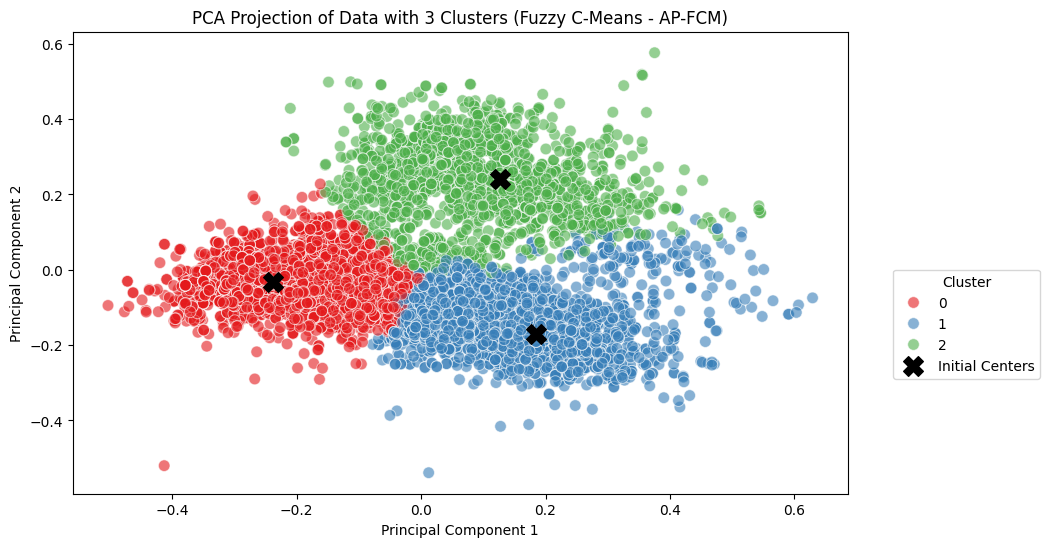

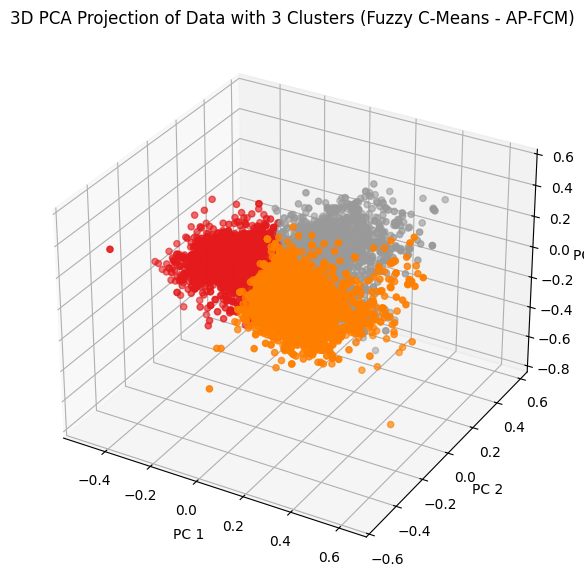

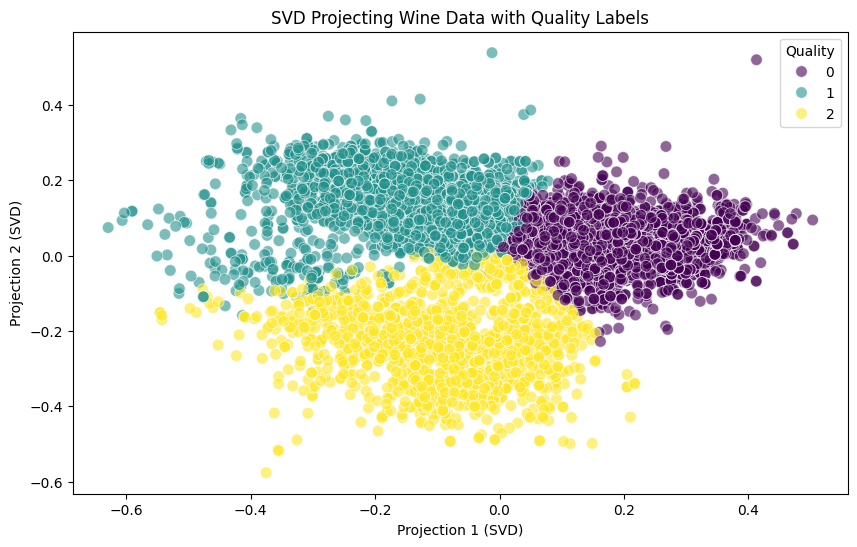

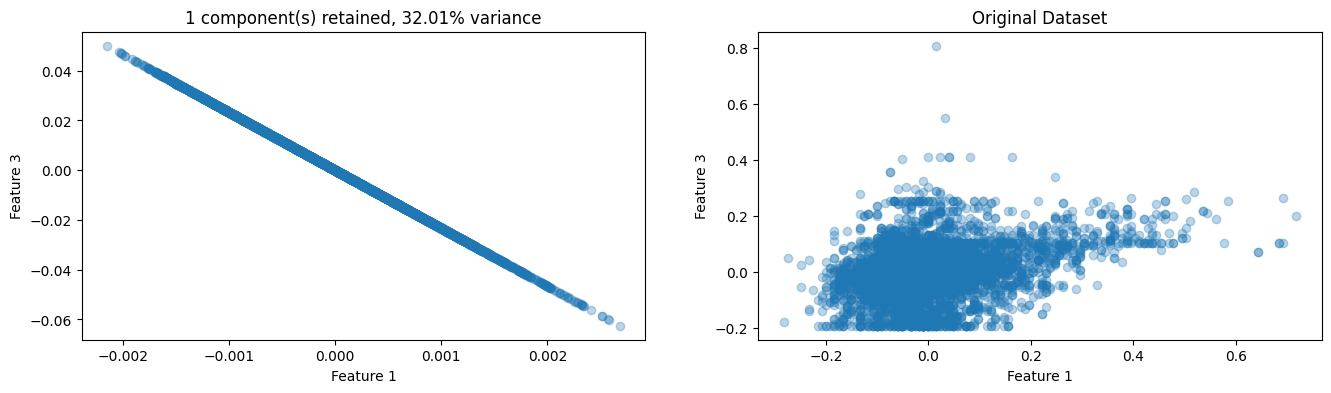

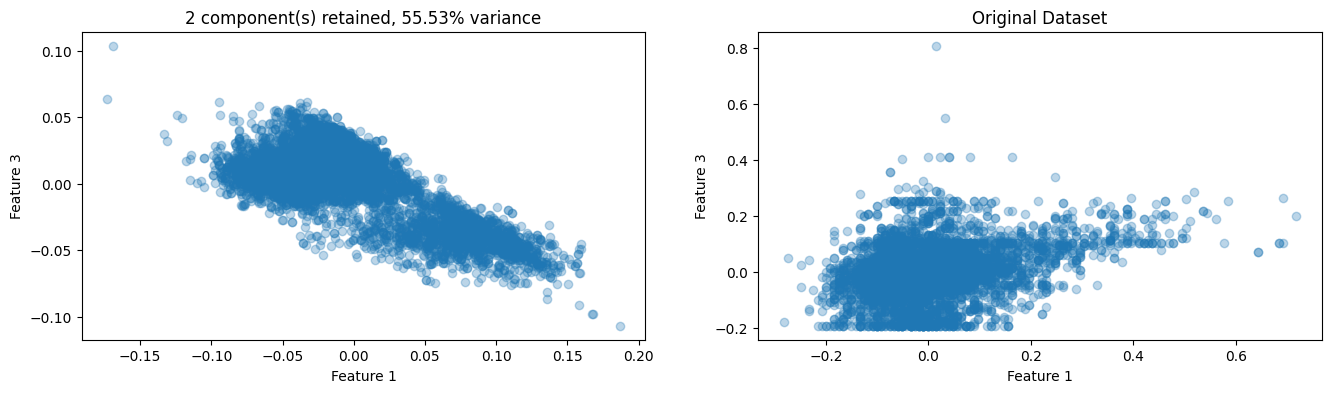

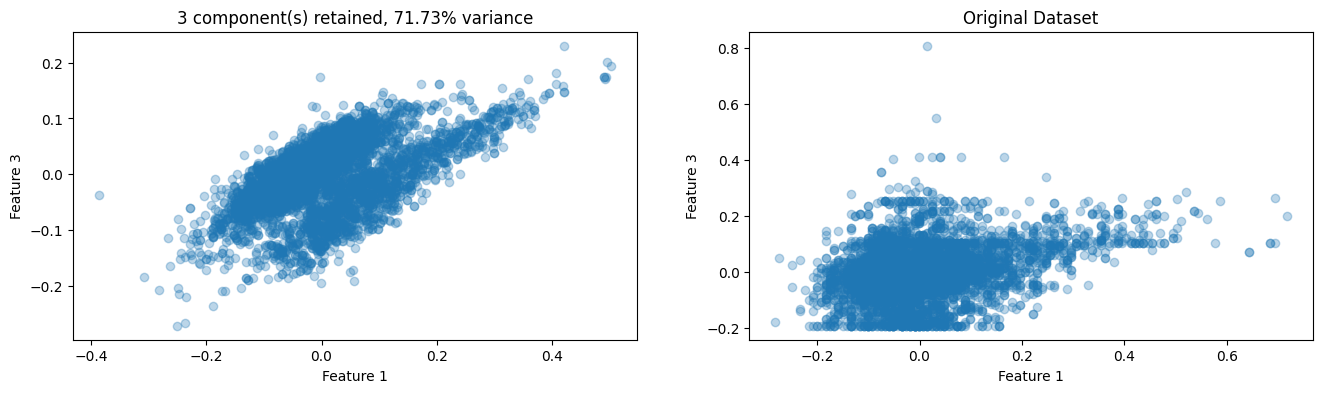

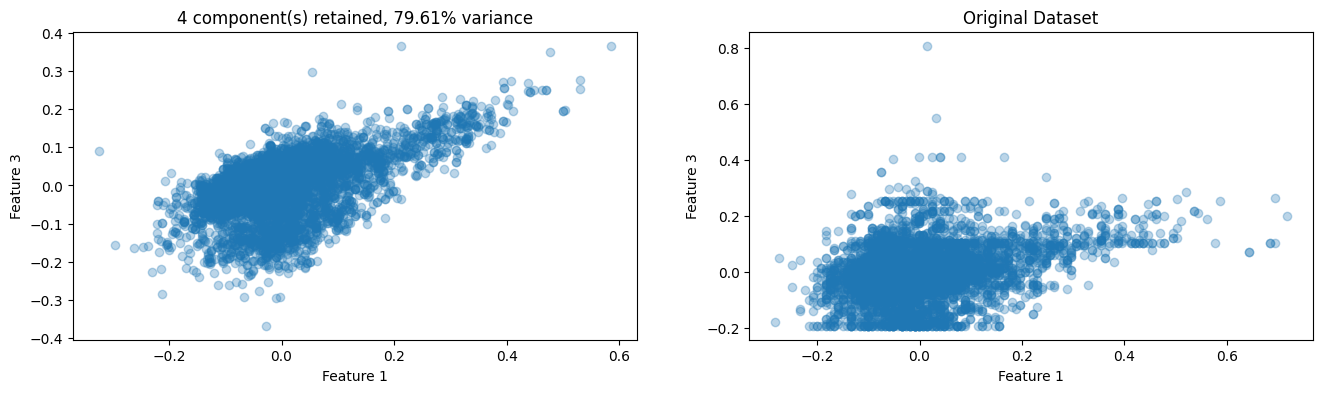

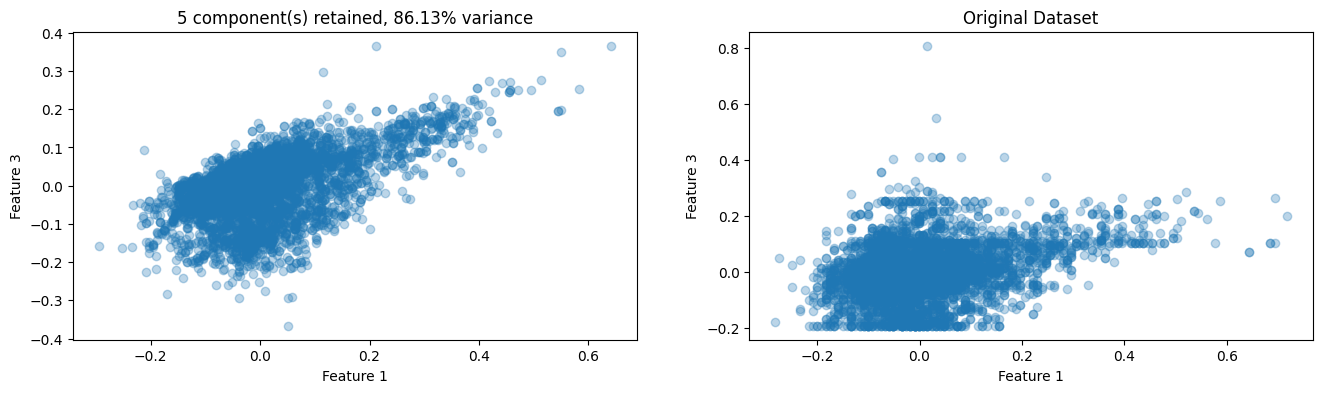

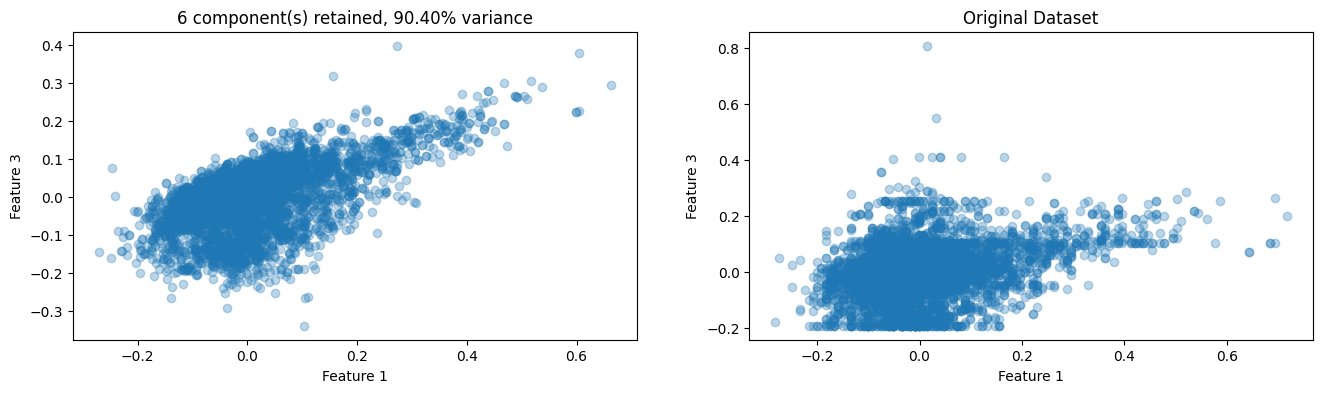

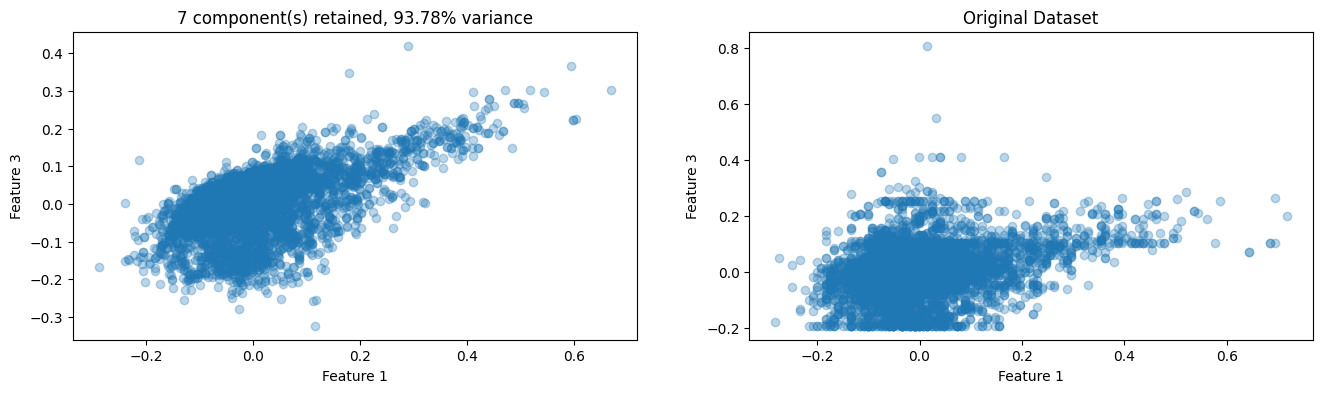

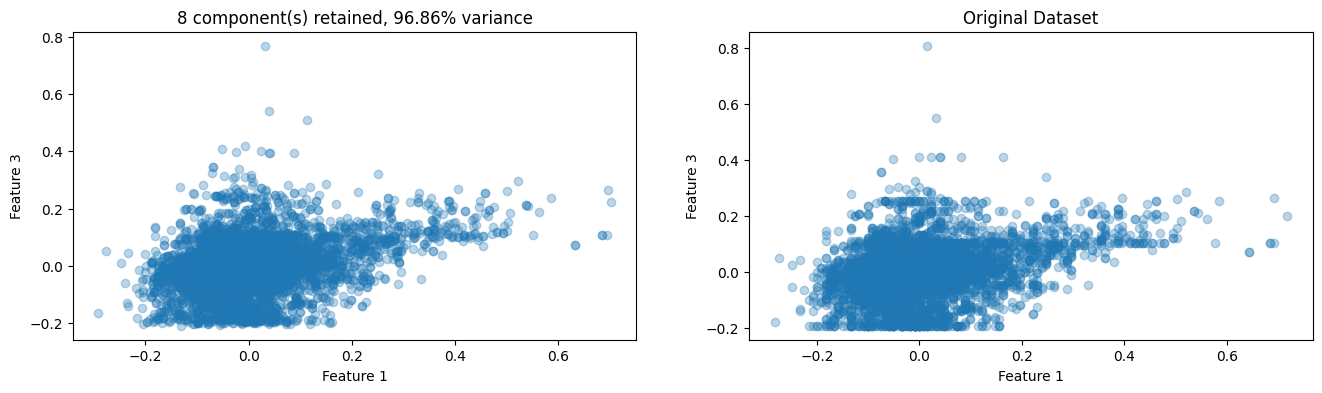

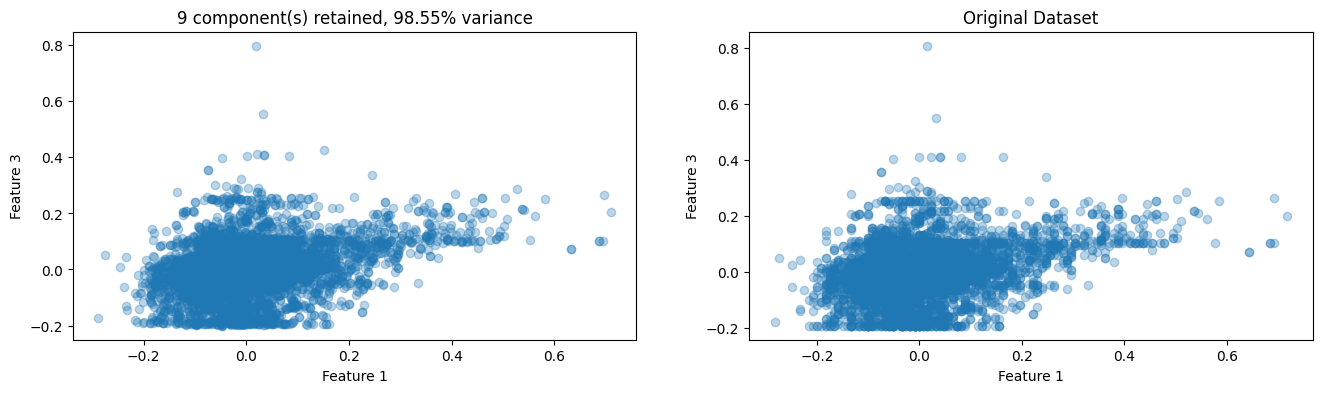

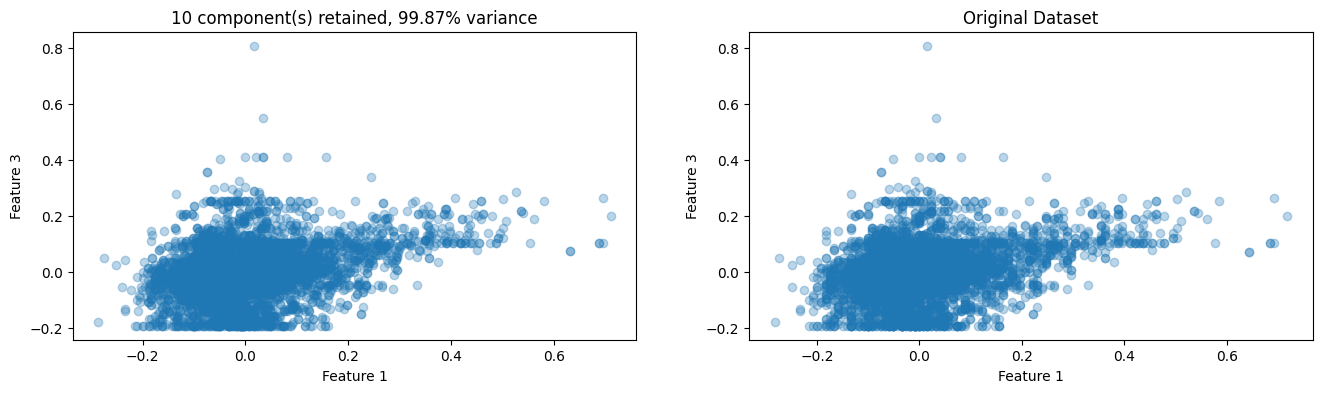

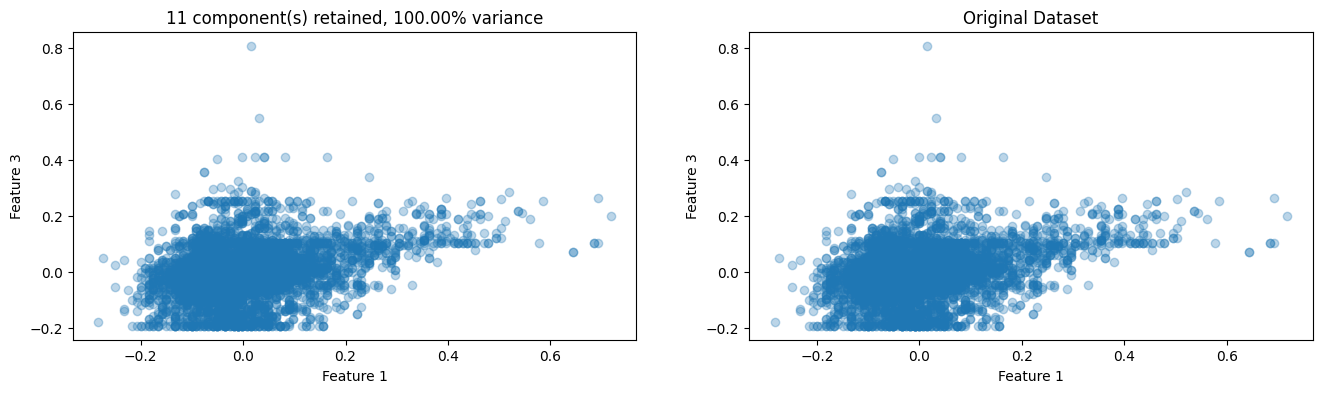

In [51]:
# b) 
c = 3
init_centroids = cent[:c]

print(init_centroids)

# Build init partition for this c
init_partition = np.zeros((x.shape[0], c))
for index, d in enumerate(x):
    dists = [np.linalg.norm(d - c_) for c_ in init_centroids]
    dists = np.fmax(dists, 1e-6)
    inv_dists = 1.0 / dists
    memberships = inv_dists / np.sum(inv_dists)
    init_partition[index] = memberships
    

centers, fm, im, d, jm, i, fpc = fuzz.cluster.cmeans(
    x_norm.T, c, 2.0, 1e-5, 100, init=init_partition.T)

fuzzy_membership = np.argmax(fm, axis=0)

# Validation Indices
xie_score = xie_beni_index(fm, centers, x_norm)
sil_score = silhouette_score(x_norm, fuzzy_membership)
ari = adjusted_rand_score(y_values, fuzzy_membership)
print(f"c={c} | Xie-Beni={xie_score:.4f} | Silhouette={sil_score:.4f} | ARI={ari:.4f}")

################################################################ PCA #####################################################################################

# Perform PCA on the normalized data (sy)
data_pca, init_centroids_pca = pca_application(x_norm, y_values,init_centroids)

# 2D/3D PCA Visualization for fuzzy partitions
plot_2d_3d_pca(data_pca, fuzzy_membership, c, init_centroids_pca)

################################################################ SVD #####################################################################################

plot_svd_projection(x_norm, x_values, y_values, fuzzy_membership)
